In [1]:
import pickle
import os
import re
import numpy as np
import spacy
import tensorflow as tf
import tensorflow.keras as K
from datetime import datetime
from sklearn.preprocessing import normalize as scikit_normalize
from evaluation import plot_history
from evaluation import rmse_report
from sampling import UnderSampler
from fasttext_embedding import FastTextEmbeddingBag
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm import tqdm

%matplotlib inline
%load_ext tensorboard

In [2]:
DATASET='/home/kvassay/data/z/data/reviews_train_test_dev1_{}.pickle'
TYPE='lem_tok'
TB_LOG_DIR='/home/kvassay/data/z/log/E3b/scalars/'
VEC_DIM=100
FASTTEXT='/home/kvassay/data/z/models/fasttext/cbow_lem_{}_e{}_w{}.bin'.format(VEC_DIM,50,5)
ALLOWED_SPECIAL=tuple(['?','!',':(', ':)', ':D',':-)',':-D',':\'(',':/',':-/','<3',':-P',':P'])

## Read data

In [3]:
%%time
with open(DATASET.format(TYPE),'rb') as f:
    train,dev,_=pickle.load(f)

CPU times: user 4.68 s, sys: 1.04 s, total: 5.73 s
Wall time: 5.94 s


## Load models

In [4]:
%%time
fasttext=FastTextEmbeddingBag(FASTTEXT)

CPU times: user 2.07 s, sys: 1.22 s, total: 3.3 s
Wall time: 8.26 s


## Preprocess text + extract features
- filter out EN stop-words (and, or, ...)
- filter out non-allowed special tokens (we want to keep smileys and !,?)
- filter out short words (1-2 characters)

In [5]:
rx_special= re.compile("|".join(re.escape(s) for s in ALLOWED_SPECIAL))

def word_filter(word):
    if word in STOP_WORDS:
        return False
    if not word.isalpha():
        if not rx_special.findall(word):
            return False
    else:
        if len(word)<3:
            return False
    return True

def preprocess_text(text):
    return [x.lower() for x in text if word_filter(x.lower())]

def preprocess_texts(dataset,text_keys=['summary','text']):
    for sample in tqdm(dataset):
        for key in text_keys:
            sample[key]=preprocess_text(sample[key])
    return dataset

In [6]:
%%time
train=preprocess_texts(train)
dev=preprocess_texts(dev)

100%|██████████| 8527/8527 [00:00<00:00, 27539.37it/s]

CPU times: user 18.1 s, sys: 114 ms, total: 18.2 s
Wall time: 18.1 s


## Extract features
- transform texts to averages of their fastText vectors
- concatenate summary & text average vectors into single one

In [7]:
def extract_features(dataset, fasttext):
    default_vec=np.zeros(VEC_DIM,dtype=np.float32)
    vecs=[]
    for sample in tqdm(dataset):
        if sample['summary']:
            vecs_summary=fasttext.forward([x for x in sample['summary']])
        else:
            vecs_summary=[default_vec]
        if sample['text']:
            vecs_text = fasttext.forward([x for x in sample['text']])
        else:
            vecs_text=[default_vec]
        avg_summary = np.mean(vecs_summary,axis=0)
        avg_text = np.mean(vecs_text,axis=0)
        vecs.append(np.concatenate((avg_summary,avg_text), axis=0))
    vecs=np.array(vecs)
    return scikit_normalize(vecs)

In [8]:
%%time
X_train=extract_features(train,fasttext)
X_dev=extract_features(dev,fasttext)
y_train=np.array([x['score'] for x in train])
y_dev=np.array([x['score'] for x in dev])
print('Train samples shape: {}, Dev samples shape: {}'.format(X_train.shape,X_dev.shape))

100%|██████████| 8527/8527 [00:05<00:00, 1527.91it/s]

Train samples shape: (551399, 200), Dev samples shape: (8527, 200)
CPU times: user 5min 48s, sys: 10.8 s, total: 5min 59s
Wall time: 5min 46s


## Train
- shallow sequential NN

In [9]:
def get_tb_callback():
    suffix=datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir= os.path.join(TB_LOG_DIR,suffix)
    return K.callbacks.TensorBoard(log_dir=os.path.join(log_dir))

def penalized_loss(y_true, y_pred):
    return K.backend.mean(K.backend.square(K.backend.abs(y_true - y_pred))/y_true)

def train_model(batch_size,learning_rate, epochs,steps):
    DROPRATE=0.1
    tensorboard_callback = get_tb_callback()
    model = K.models.Sequential([
        K.layers.Dense(256,activation='relu', input_shape=(X_train.shape[1],)),
        K.layers.Dense(1,activation='linear'),
    ])
    opt=K.optimizers.Adam(lr=learning_rate, decay=learning_rate/epochs)
    model.compile(optimizer=opt, loss=penalized_loss,metrics=[penalized_loss])
    sampler=UnderSampler(X_train,y_train,batch_size=batch_size)
    model.fit_generator(sampler,
                        shuffle=False,
                        epochs=epochs,
                        steps_per_epoch=steps,
                        validation_data=(X_dev,y_dev),
                        callbacks=[tensorboard_callback])
    return model

## Experiment

In [10]:
def experiment(learning_rate,epochs,batch_size,name,steps):
    model=train_model(epochs=epochs,batch_size=batch_size,learning_rate=learning_rate,steps=steps)
    y_pred_dev=model.predict(X_dev)
    rmse_report(y_dev,y_pred_dev,title='{} - RMSE report'.format(name))
    plot_history(model,title='{} - Train/Dev MSE'.format(name))
    return model

Epoch 1/60
300/300 [==============================] - 3s 12ms/step - loss: 0.5873 - penalized_loss: 0.5873 - val_loss: 0.5314 - val_penalized_loss: 0.5314
Epoch 2/60
300/300 [==============================] - 4s 14ms/step - loss: 0.4402 - penalized_loss: 0.4402 - val_loss: 0.4718 - val_penalized_loss: 0.4718
Epoch 3/60
300/300 [==============================] - 4s 12ms/step - loss: 0.4282 - penalized_loss: 0.4282 - val_loss: 0.4685 - val_penalized_loss: 0.4685
Epoch 4/60
300/300 [==============================] - 5s 15ms/step - loss: 0.4194 - penalized_loss: 0.4194 - val_loss: 0.5290 - val_penalized_loss: 0.5290
Epoch 5/60
300/300 [==============================] - 4s 12ms/step - loss: 0.4105 - penalized_loss: 0.4105 - val_loss: 0.4990 - val_penalized_loss: 0.4990
Epoch 6/60
300/300 [==============================] - 4s 13ms/step - loss: 0.4052 - penalized_loss: 0.4052 - val_loss: 0.5011 - val_penalized_loss: 0.5011
Epoch 7/60
300/300 [==============================] - 3s 11ms/step - l

RMSE (baseline ∀1.0),1.53
RMSE,1.32
Mean partial RMSE (baseline ∀1.0),2.0
Max partial RMSE (baseline ∀1.0),1.414
St.dev. partial RMSE (baseline ∀1.0),4.0
Mean partial RMSE,0.977
Max partial RMSE,0.296
St.dev. partial RMSE,1.497
RMSE,0.21
Mean partial RMSE,1.023
Max partial RMSE,2.503


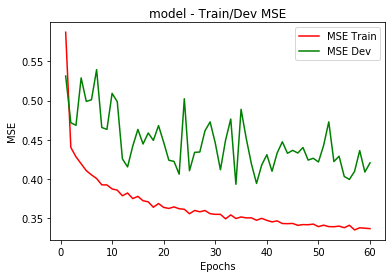

In [11]:
model=experiment(learning_rate=0.04,epochs=60,batch_size=256,steps=300,name='model')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               51456     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 51,713
Trainable params: 51,713
Non-trainable params: 0
_________________________________________________________________


In [13]:
## Persist model

In [14]:
model.save('/home/kvassay/data/z/models/E3b/keras_regressor.h5')